In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
from module.apps import App, PlotSim, PlotSim2
import ipywidgets as widgets
import matplotlib.pyplot as plt
from module.utils import drias2020
from matplotlib.dates import DateFormatter

## Exemple d'une étude d'impact changement climatique avec un modèle hydrologique global pluie-débit-niveau 

Cet exercice reprend l'exemple du modèle "Selle et Morvillers" disponible dans le tutoriel du logiciel Gardénia (https://gardenia.brgm.fr) et se propose d'exploiter les projections climatiques régionalisées DRIAS2020 afin de réaliser une étude d'impact changement climatique sur le bassin de la Selle.

La démarche proposée se base sur un utilitaire en ligne créé pour les besoins de la présente formation. Son fonctionnement repose sur les principes de base de Gardénia. Il ne s'applique qu'au modèle "Selle et Morvillers" et ses résultats ne doivent pas être interprétés en-dehors du cadre de la formation. Cet utilitaire très simple n'a fait l'objet d'aucune validation plus poussée et n'offre pas l'étendu des possibilités de Gardénia. 

La rivière Selle est un affluent du fleuve de la Somme située au nord de la France. La superficie de son bassin versant est de 540 km². On dispose de deux chroniques de pluie et d'ETP moyennées sur 9 stations météorologiques (cf. Figure 2). On dispose d'une chronique journalière de débit à la station hydrométrique "Selle à Plachy" de 1989 à 2003 et d'une chronique piézométrique mensuelle au piézomètre de Morvillers de septembre 1985 au 15 juillet 2003.

| <img src="bassin_selle.png" alt="Bassin de la Selle" width="500"/> |
|---|
| *Figure 1 : Bassin de la Selle. Le piézomètre de Morvillers et la station hydrométrique de la Selle à Plachy sont indiqués en rouge. La grille correspond à la grille de 8 km de résolution des données DRIAS 2020* |


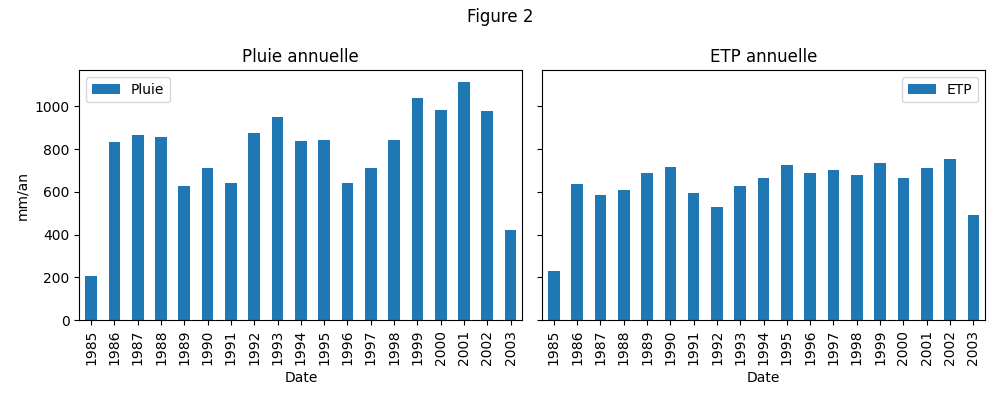

In [2]:
fig, ax = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches((10,4))
fig.canvas.header_visible = False
fig.suptitle('Figure 2')
df = pd.read_csv("Selle_et_Morvillers/Pluv_Moy_9_Stat_Selle_1985_2003.prn", dayfirst=True, parse_dates=True, delim_whitespace=True, index_col=0)
df = df.resample('Y').sum()
df.index = df.index.year
df.plot(ax=ax[0], title='Pluie annuelle', ylabel='mm/an', kind='bar')
df = pd.read_csv("Selle_et_Morvillers/Etp_Moy_9_Stat_Selle_1985_2003.prn", dayfirst=True, parse_dates=True, delim_whitespace=True, index_col=0)
df = df.resample('Y').sum()
df.index = df.index.year
df.plot(ax=ax[1],title='ETP annuelle', ylabel='mm/an', kind='bar')
plt.tight_layout()

***
# Calage du modèle
L'objectif de cette première partie est de calibrer le modèle à partir des données pluviométriques et d'ETP disponibles sur la période 1985-2003. La calibration s'effectue en ajustant les chroniques simulées de débit et de hauteur de nappe à celles observés en modifiant les paramètres de calage du modèle. Le contrôle de l qualité du calage s'effectue en contrôlant les valeurs de KGE et de Nash du débit, et la valeur de Nash du piézomètre, ainsi que de manière visuelle.

L'utilitaire ci-dessous permet de réaliser la calibration et de tester les paramètres de calage. Un menu s'affiche lorsque la souris passe sur le graphique. Il est possible ainsi de zoomer et d'enregistrer l'image en local.

1. En faisant jouer les paramètres de calage, discuter du rôle que chaque paramètre exerce sur la simulation du débit et de la piézométrie.
1. Calibrer le modèle manuellement en faisant jouer les paramètres du modèle de manière à maximiser les critères de qualité
2. Noter les paramètres obtenus manuellement et calibrer de manière automatique le modèle en appuyant sur le bouton "Optimiser". Comparer les deux jeux de paramètres obtenus
***

In [12]:
pluie_obs = pd.read_csv(
    "Selle_et_Morvillers/Pluv_Moy_9_Stat_Selle_1985_2003.prn",
    delim_whitespace=True,
    parse_dates=True,
    dayfirst=True,
    index_col=0
)

etp_obs = pd.read_csv(
    "Selle_et_Morvillers/Etp_Moy_9_Stat_Selle_1985_2003.prn",
    delim_whitespace=True,
    parse_dates=True,
    dayfirst=True,
    index_col=0
)

debit = pd.read_csv(
    "Selle_et_Morvillers/Debit_Selle_Plachy_1985_2003.prn",
    delim_whitespace=True,
    parse_dates=True,
    dayfirst=True,
    index_col=0,
)['Debit']
debit = debit.replace(-2, np.nan)

niveau = pd.read_csv(
    "Selle_et_Morvillers/Niv_Morvillers_00608X0028_1985_2003.prn",
    delim_whitespace=True,
    parse_dates=True,
    dayfirst=True,
    index_col=0,
)['Niveau']
niveau = niveau.replace(9999., np.nan)

In [13]:
app = App(debit, niveau)
app.set_meteo(pluie_obs, etp_obs)
column1 = widgets.VBox(
    [
        widgets.Label("Paramètres", style=dict(font_weight="bold", background='lightblue')),
        app.widgetA,
        app.widgetR,
        app.widgetTHG,
        app.widgetTG1,
        app.widgetbaseNiv,
        app.widgetcoeffEmmag,
        widgets.Label("Critères", style=dict(font_weight="bold", background='lightblue')),
        app.textNash,
        app.textKGE,
        app.textNashNiv
    ],
    layout=widgets.Layout(width='35%')
)

column2 = widgets.VBox(
    [
        app.btnOpti,
        app.fig.canvas,
    ]
)

widgets.HBox([column1, column2])

***
# Etude d'impact changement climatique

L'objectif de cette partie est d'utiliser les projections climatiques régionalisées DRIAS2020 disponibles en ligne (http://www.drias-climat.fr/) afin de produire des projections hydrologiques de débits et de piézomètre avec notre modèle déjà calibré. 

## Réaliser les simulations

Pour les besoins de cet exercice, les données DRIAS2020 ont déjà été téléchargées et pré-traitées pour être utilisés dans le modèle. Ces données correspondent aux chroniques journalières de pluies et d'ETPs des 12 couples GCM/RCM disponibles dans DRIAS2020 pour la période historique de 1950 (ou 1970 selon le modèle) à 2005 pour la période historique, et de 2005 à 2100 pour les scénarios RCPs. Le pré-traitement consiste à :
- identifier les mailles de la grille DRIAS2020 correspondant au modèle "Selle et Morvillers". Ces mailles correspondent à la grille de 8 km de côté se superposant au bassin versant de la Selle sur la Figure 1.
- à chaque pas de temps, réaliser une moyenne pondérée des valeurs de pluies et d'ETPs. La pondération tient compte de la surface relative de bassin versant à l'intérieur de chaque maille de la grille DRIAS2020.

Au final, cela représente 30 simulations de notre modèle hydrologique à lancer pour produire des chroniques de 1950 à 2100 pour chaque RCP et chaque modèle climatique.

Lancer les simulations en cliquant sur le bouton "Lancer" ci-dessous. Les simulations sont terminées quand la barre de progression est complétée.

In [14]:
def run_simulations(b):
    btn.disabled = True
    progress.value = 0
    for gcm, rcm, period in drias2020:
        pluie = 'sims_cc/{0}_{1}_{2}/Pluie_Selle_et_Morvillers_{0}_{1}_{2}'.format(
            gcm,
            rcm,
            period
        )
        pluie = pd.read_csv(
            pluie,
            delim_whitespace=True,
            parse_dates=True,
            dayfirst=True,
            index_col=0
        )
        etp = 'sims_cc/{0}_{1}_{2}/ETP_Selle_et_Morvillers_{0}_{1}_{2}'.format(
            gcm,
            rcm,
            period
        )
        etp = pd.read_csv(
            etp,
            delim_whitespace=True,
            parse_dates=True,
            dayfirst=True,
            index_col=0
        )
        app.set_meteo(pluie, etp)
        app.run(-9999)
        os.makedirs('results_cc', exist_ok=True)
        app.result.to_csv(
            'results_cc/{0}_{1}_{2}.csv'.format(
                gcm, rcm, period
            ),
        )
        progress.value += 1
    app.set_meteo(pluie_obs, etp_obs)
    btn.disabled = False
    progress.value = 0
btn = widgets.Button(
    description='Lancer',
    disabled=False,
    icon='check'
)
btn.on_click(run_simulations)
progress = widgets.IntProgress(
    value=0,
    min=0,
    max=len(drias2020),
    bar_style='info', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)
widgets.HBox([btn, progress])

***
## Analyse des résultats
### Tracé des chroniques
L'utilitaire ci-dessous permet de représenter les résultats sous forme de chroniques temporelles de débit et de piézomètre. Il se compose de plusieurs rubriques.

- La rubrique Modèles permet de sélectionner les modèles climatiques à tracer. La sélection multiple est possible à la souris en maintenant la touche ctrl.
- La rubrique RCPs permet de sélectionner les RCPs à tracer. La sélection multiple est possible à la souris en maintenant la touche ctrl.
- La rubrique Variable permet de sélectionner Débit ou Niveau de nappe
- L'indicateur propose un tracé en journalier, en minimum/moyenne/maximum mensuel ou annuel
- La rubrique tracé propose un tracé :
    - en "Spaghetti", c'est-à-dire tous les modèles représentés sur une même figure
    - sous forme d'ensemble en Q5/Médiane/Q95, avec la médiane des modèles sélectionnés et une enveloppe représentant le quantile 5 et le quantile 95 de l'ensemble des modèles.
    - sous forme d'ensemble en Minimum/Moyenne/Maximum.
- La case à cocher "Anomalie" permet de représenter les résultats en anomalie par rapport à la moyenne interannuelle sur la période de référence 1976-2005.

### Test de Mann-Kendall
Si un indicateur annuel est tracé, un test de Mann-Kendall est réalisé et les résultats s'affichent dans un tableau sous le graphique.  Le test est réalisé avec le package "pymannkendall" (https://pypi.org/project/pymannkendall/). Il indique :
- La tendance détectée ("decreasing", "increasing", "no-trend")
- La significativité du test sous forme de "p-value". Si la p-value est inférieur à 5 % (0.05) le test est significatif et une tendance est détectée. Dans le cas contraire, la tendance n'est pas significative.

### Questions

| <img src="donnes_modeles.png" alt="" width=600/> | <img src="selection_drias2020.png" alt="" width=400/> |
|---|---|
| *Figure 2 : Position des modèles à l'horizon fin de sicèle pour le RCP 8.5 en moyenne sur la France* | *Figure 3 : Modèles disponibles dans DRIAS 2020* |

La Figure 2 ci-dessus permet d'appréhender la position des projections climatiques disponibles dans DRIAS2020 par rapport à leur degré de réchauffement en ordonnée, et leur évolution en terme de précipitation, à l'horizon fin de siècle pour le scénario RCP 8.5 et en moyenne sur toute la France. On voit que la médiane des modèles induit une augmentation des précipitations sur la France avec un réchauffement d'environ 3.9 °C. La Figure 3 rappelle les modèles disponibles dans DRIAS2020 selon les scénarios RCPs.

1. Sur la Figure 2, quel est le modèle le plus humide ? A l'inverse, quel est le plus sec ?
2. Dans un premier temps, sélectionnez le modèle le plus sec et un ou plusieurs scénarios RCPs et testez les différentes représentations proposées. Pour les indicateurs annuels, quelles sont les tendances relevées pour ce modèle ?
3. Même question concernant le modèle le plus humide.
4. En sélectionnant l'ensemble des modèles, testez les représentations en "Spaghetti", "Q5/Médiane/Q95" et "Min/Moy/Max". Pour ces deux dernières, quelles sont les tendances détectées ?
5. Comment évolue l'incertitude des modèles avec le temps ? Quel scénario RCP présente le plus d'incertitude ?
6. Par rapport à la figure 2, si vous deviez effectuer une sélection de 5 modèles représentatifs des 12 modèles en termes de changement de température et de précipitations, lesquels choisiriez-vous ? Calculez les tendances pour cette sélection  et comparez la par rapport aux tendances calculées précédemment.

***

In [15]:
plot = PlotSim()
widgets.VBox([plot.main, plot.label, plot.out])

### Analyse en cycles saisonniers

Cette partie reprends les résultats précédents et propose une représentation sous forme de cycles saisonniers journaliers ou mensuels calculés sur la période historique de référence 1976-2005, et les trois périodes futures 2021-2050, 2041-2070 et 2071-2100. Les anomalies sont calculées par rapport au cycle saisonnier sur la période 1976-2005. En complément, les valeurs en moyennes interannuelles sont indiquées à la suite du graphique.

Vous pouvez tester librement les différentes représentations possibles ou reprendre les sélections de modèles proposées dans les questions précédentes et tester soit l'évolution des courbes selon les RCPs, pour un horizon donné, soit l'évolution des courbes selon les horizons futurs, pour un RCP donné.

In [38]:
plot2 = PlotSim2()
widgets.VBox([plot2.main, plot2.label, plot2.out])